In [40]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Spotify Genres - Data Mining
## 1: Business objective
Maintaining radio stations or constructing playlists of high quality can be an expensive and daunting task. People enjoying these forms of listening to music may expect that songs offered by any particular source should be as similar to each other as possible - combining somber and lively pieces steer the audience towards the other providers.  
Therefore, it is crucial to find a number of sets/clusters of music tracks that could be viably combined together into a single playlist or radio station. The number of presented options should not be too high (maintaining many stations/playlists is not profitable) and tracks/songs should obviously be relatively similar to others composing the same cluster.
## 2: Dataset
The dataset we are using for this task can be found on kaggle (https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) and comprises data obtained using Spotify API. Although a variety of data can be found in this dataset, we will mostly limit ourselves to one of the files: data_o.csv (data regarding particular tracks), with every song being described with parameters portraying musical properties like:
* acousticness (0-1)
* danceability (0-1)
* energy (0-1)
* duration (usually between 200k and 300k in miliseconds)
* instrumentalness (0-1)
* valence (0-1)
* tempo (50-150)
* liveness (0-1)
* loudness (-60-0)
* speechiness (0-1)
* mode (0=minor, 1=major)
* key (categorical, 0-11).  

In [2]:
genres_df = pd.read_csv('data/data_by_genres_o.csv')
tracks_df = pd.read_csv('data/data_o.csv')

In [34]:
genres_df.head()

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7


In [35]:
tracks_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [4]:
for col in tracks_df.columns:
    print(f"{col} - {len(tracks_df[col].unique())}")
    if col == 'genres':
        with open('genres.txt', 'w') as genfile:
            for genre in genres_df[col].unique():
                genfile.write(f"{genre}\n")

valence - 1733
year - 100
acousticness - 4689
artists - 34088
danceability - 1240
duration_ms - 51755
energy - 2332
explicit - 2
id - 170653
instrumentalness - 5401
key - 12
liveness - 1740
loudness - 25410
mode - 2
name - 133638
popularity - 100
release_date - 11244
speechiness - 1626
tempo - 84694


In [5]:
genres_df.quantile([0, .05, .25, .5, .75, .95, 1])

,mode,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0.00,0.0,0.000003,0.056900,3.094600e+04,0.001002,0.000000e+00,0.022200,-41.825000,0.023800,47.135722,0.003353,0.000000,0.0
0.05,0.0,0.002896,0.272964,1.592197e+05,0.134736,5.684560e-07,0.090093,-21.612462,0.033700,91.097557,0.159334,1.492857,0.0
0.25,1.0,0.119050,0.441202,2.063788e+05,0.395058,4.835163e-03,0.137687,-12.427656,0.044900,109.198143,0.348578,32.491279,3.0
0.50,1.0,0.321745,0.546496,2.375453e+05,0.601195,8.069972e-02,0.178764,-9.221817,0.059457,119.194167,0.500048,43.056569,7.0
0.75,1.0,0.673991,0.647500,2.772720e+05,0.730127,3.433333e-01,0.220856,-6.920125,0.091000,127.508750,0.640257,51.138889,9.0
0.95,1.0,0.961811,0.766000,3.780158e+05,0.908680,8.234000e-01,0.346000,-4.582203,0.212180,146.985089,0.823545,61.819048,11.0
1.00,1.0,0.996000,0.929000,2.382587e+06,0.994667,9.920000e-01,0.960000,0.060000,0.946219,204.212000,0.980000,80.666667,11.0


In [6]:
scaler = preprocessing.StandardScaler()
genres_stand = genres_df.drop(['genres'], axis=1)

genres_stand = pd.DataFrame(
    scaler.fit_transform(genres_stand),
    index=genres_stand.index,
    columns=genres_stand.columns
)

In [7]:
genres_stand = pd.concat([genres_df['genres'], genres_stand], axis=1)

In [8]:
genres_stand

,genres,mode,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,21st century classical,0.447484,1.808197,-2.484719,-0.966000,-2.089283,1.479575,1.828029,-3.912689,-0.534628,-2.500950,-1.927609,-0.721720,0.018179
1,432hz,0.447484,0.292578,-1.578931,8.423062,-0.471170,0.996674,-0.669260,-1.181781,-0.084146,0.072537,-1.342996,0.751277,-0.278774
2,8-bit,0.447484,1.128407,1.160449,-1.442757,1.095589,2.486616,-0.723408,0.247722,-0.454680,0.825894,2.389920,0.482555,0.315131
3,[],0.447484,0.782518,-0.053735,-0.199068,-0.605666,-0.022662,0.280445,-0.331412,0.301775,-0.352759,0.103360,-1.138147,0.315131
4,a cappella,0.447484,0.861153,0.011776,-0.645517,-1.043772,-0.779555,-0.222497,-0.366883,-0.009152,-0.395526,-0.220526,0.352378,0.315131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,zolo,0.447484,-0.558687,0.065680,0.067394,0.209416,-0.252520,0.123529,-0.146421,-0.279609,0.370783,0.512461,-0.366671,0.909036
2969,zouglou,-2.234715,-0.751442,2.162823,-0.479717,1.483736,-0.790792,-0.918340,0.842883,-0.028431,0.001104,1.745673,1.079716,0.315131
2970,zouk,0.447484,-0.431582,1.405326,0.574296,0.261474,0.171580,-1.116761,0.041098,-0.556859,-0.976369,1.642153,0.402933,-0.278774
2971,zurich indie,-2.234715,1.850944,1.118406,-0.563218,-1.656989,0.962521,-0.142223,-0.175751,3.294156,-1.588247,1.220364,-2.383818,0.315131


## 3 - Preprocessing
There are no missing values in our dataset regarding Spotify tracks, hence we do not need to impute any values. However, that does not mean there is nothing we should take care of before applying clusterisation algorithm.

### 3.1 - Feature selection
The data being clustered should be free of any IDs or any attributes that would be able to distract the algorithm from "real" distinguishing factors. Therefore, the first action we take is removing the id/name/year/artist attributes.

In [9]:
tracks = tracks_df.drop(['id', 'name', 'release_date', 'year', 'artists'], axis=1)

In [10]:
print('Shape:', tracks.shape)
tracks.head()

Shape: (170653, 14)


,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,0.0594,0.982,0.279,831667,0.211,0,0.878000,10,0.665,-20.096,1,4,0.0366,80.954
1,0.9630,0.732,0.819,180533,0.341,0,0.000000,7,0.160,-12.441,1,5,0.4150,60.936
2,0.0394,0.961,0.328,500062,0.166,0,0.913000,3,0.101,-14.850,1,5,0.0339,110.339
3,0.1650,0.967,0.275,210000,0.309,0,0.000028,5,0.381,-9.316,1,3,0.0354,100.109
4,0.2530,0.957,0.418,166693,0.193,0,0.000002,3,0.229,-10.096,1,2,0.0380,101.665


In [11]:
for col in tracks.columns:
    print(f"{col} - {len(tracks[col].unique())}")

valence - 1733
acousticness - 4689
danceability - 1240
duration_ms - 51755
energy - 2332
explicit - 2
instrumentalness - 5401
key - 12
liveness - 1740
loudness - 25410
mode - 2
popularity - 100
speechiness - 1626
tempo - 84694


### 3.2 - Standardisation
Since both outlier removal and clustering algorithm used by us are based on distance metrics, we need to standardise the values of numerical attributes in order to ensure equal impact of all attributes beforehand and after any operation that may "de-standardise" the data.

In [12]:
scaler = preprocessing.StandardScaler()

tracks_stand = pd.DataFrame(
    scaler.fit_transform(tracks),
    index=tracks.index,
    columns=tracks.columns
)

In [13]:
tracks_stand

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,-1.782825,1.276187,-1.467013,4.763146,-1.013988,-0.303955,2.268102,1.365588,2.626719,-1.514237,0.643912,-1.256808,-0.379706,-1.169307
1,1.650688,0.611347,1.598779,-0.399747,-0.528270,-0.303955,-0.532771,0.512123,-0.262229,-0.170766,0.643912,-1.210993,1.945481,-1.821180
2,-1.858821,1.220340,-1.188820,2.133824,-1.182122,-0.303955,2.379754,-0.625830,-0.599749,-0.593551,0.643912,-1.210993,-0.396297,-0.212404
3,-1.381564,1.236296,-1.489722,-0.166101,-0.647832,-0.303955,-0.532682,-0.056853,1.002043,0.377680,0.643912,-1.302624,-0.387080,-0.545537
4,-1.047180,1.209703,-0.677855,-0.509485,-1.081242,-0.303955,-0.532765,-0.625830,0.132499,0.240788,0.643912,-1.348440,-0.371104,-0.494867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.301754,-1.110321,1.411425,0.561107,1.216579,-0.303955,-0.531849,0.512123,-0.707298,1.362950,0.643912,1.858663,-0.063250,-0.385320
170649,0.780531,-0.787475,1.019685,-0.636660,1.011083,-0.303955,-0.532771,0.512123,-0.599749,0.956136,0.643912,1.675400,-0.232846,0.686274
170650,0.411949,-1.066708,0.548461,-0.155952,1.403394,-0.303955,-0.532743,-0.341342,0.298399,1.621992,-1.553007,2.041926,-0.107492,-0.819761
170651,-1.267570,-1.308762,0.758525,0.842058,0.525365,3.289955,-0.532746,-0.910318,2.500864,0.755887,0.643912,1.767032,1.287989,-1.361404


In [14]:
tracks_stand.quantile([0, .05, .25, .5, .75, .95, 1])

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0.00,-2.008534,-1.335303,-3.051005,-1.790706,-1.802346,-0.303955,-0.532771,-1.479295,-1.177539,-8.517487,-1.553007,-1.440072,-0.604606,-3.805520
0.05,-1.664650,-1.331394,-1.745205,-0.951183,-1.518388,-0.303955,-0.532771,-1.479295,-0.834870,-1.851904,-1.553007,-1.440072,-0.431937,-1.390822
0.25,-0.803992,-1.064048,-0.694887,-0.484636,-0.849591,-0.303955,-0.532771,-0.910318,-0.612335,-0.552308,-1.553007,-0.936098,-0.390153,-0.763327
0.50,0.043366,0.036926,0.060206,-0.186185,-0.042552,-0.303955,-0.532081,-0.056853,-0.399525,0.155844,0.643912,0.071849,-0.328090,-0.069446
0.75,0.829928,1.039504,0.741493,0.249383,0.824268,-0.303955,-0.207384,0.796611,0.315561,0.752026,0.643912,0.759085,-0.140060,0.608152
0.95,1.551893,1.302780,1.553360,1.432018,1.649989,3.289955,2.354234,1.650076,2.312081,1.287730,0.643912,1.583769,1.570649,1.872847
1.00,1.791281,1.313418,2.558258,41.013573,1.933947,3.289955,2.657289,1.650076,4.543149,2.689222,0.643912,3.141504,5.355837,4.124123


### 3.3 - Outlier removal
Outliers can lead to abnormal behaviour of ML and DM algorithms; therefore, we use Local Outlier Factor-based outlier detection algorithm to get rid of them.  
Local Outlier Factor measures the local deviation of density of a given sample with respect to its neighbours and in this way is able to determine how isolated any given sample is.

In [15]:
convert = lambda val: True if val == -1 else False

In [16]:
clf = LocalOutlierFactor(n_jobs=-1)

outliers = clf.fit_predict(tracks_stand.select_dtypes(exclude=object))
outliers = [convert(val) for val in outliers]

print(f"Detected {sum(outliers)} outliers ({round(sum(outliers) / len(tracks_stand) * 100, 2)}%)")

Detected 700 outliers (0.41%)


In [17]:
tracks_stand.drop(tracks_stand[outliers].index, inplace=True)

In [18]:
scaler = preprocessing.StandardScaler()

tracks_stand = pd.DataFrame(
    scaler.fit_transform(tracks_stand),
    index=tracks_stand.index,
    columns=tracks_stand.columns
)

In [19]:
tracks_stand.head(5)

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,-1.788217,1.276170,-1.472446,4.809572,-1.016118,-0.302662,2.271876,1.367000,2.629620,-1.531128,0.643402,-1.258955,-0.377875,-1.176731
1,1.650726,0.611377,1.601749,-0.403885,-0.529934,-0.302662,-0.531795,0.513036,-0.261483,-0.176582,0.643402,-1.213100,1.968997,-1.831490
2,-1.864333,1.220327,-1.193492,2.154499,-1.184412,-0.302662,2.383640,-0.625583,-0.599255,-0.602852,0.643402,-1.213100,-0.394621,-0.215591
3,-1.386322,1.236282,-1.495218,-0.167950,-0.649610,-0.302662,-0.531707,-0.056273,1.003732,0.376384,0.643402,-1.304811,-0.385317,-0.550199
4,-1.051409,1.209690,-0.681126,-0.514698,-1.083436,-0.302662,-0.531790,-0.625583,0.133539,0.238364,0.643402,-1.350666,-0.369192,-0.499304


## KNearest neighbours for given song - TESTING

In [46]:
nbrs = NearestNeighbors(n_neighbors=5).fit(tracks_stand.drop(columns=['duration_ms', 'explicit', 'key', 'mode']))

In [60]:
dist, inds = nbrs.kneighbors(tracks_stand.drop(columns=['duration_ms', 'explicit', 'key', 'mode']).iloc[9407].values.reshape(1, -1))

In [64]:
# 9407  - The Beatles - Here comes the sun
# 17008	- Kanye West  - Stronger
# 13810 - Metallica   - Nothing Else Matters
tracks_df.query('year == 1969')

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
9406,0.663,1969,0.2010,['Creedence Clearwater Revival'],0.640,140773,0.663,0,4BP3uh0hFLFRb5cjsgLqDh,0.008060,0,0.1520,-7.516,1,Fortunate Son,81,1969-11-02,0.0374,132.770
9407,0.394,1969,0.0339,['The Beatles'],0.557,185733,0.540,0,6dGnYIeXmHdcikdzNNDMm2,0.002480,9,0.1790,-10.484,1,Here Comes The Sun - Remastered 2009,82,1969-09-26,0.0347,129.171
9408,0.578,1969,0.6110,['Neil Diamond'],0.529,203573,0.127,0,62AuGbAkt8Ox2IrFFb8GKV,0.000109,11,0.2370,-16.066,1,Sweet Caroline,78,1969-06-06,0.0274,63.050
9409,0.942,1969,0.0586,['Creedence Clearwater Revival'],0.508,141600,0.774,0,20OFwXhEXf12DzwXmaV7fj,0.000005,2,0.0630,-5.973,1,Bad Moon Rising,78,1969-08-03,0.0321,178.946
9410,0.187,1969,0.0302,['The Beatles'],0.533,259947,0.376,0,2EqlS6tkEnglzr7tkKAAYD,0.248000,9,0.0926,-11.913,0,Come Together - Remastered 2009,79,1969-09-26,0.0393,165.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160548,0.880,1969,0.5630,['Freddie King'],0.697,186133,0.413,0,1nnRhyFPtT7uhoqofJkG4Q,0.000000,0,0.1020,-11.313,1,I Don't Know,22,1969,0.0566,112.034
160549,0.692,1969,0.7990,"['Johnny Cash', 'The Carter Family', 'The Stat...",0.564,240933,0.336,0,1o2cKAfdF6ywY10ZHgtpti,0.000004,6,0.9800,-15.140,1,He Turned the Water Into Wine (with The Carter...,22,1969-06-05,0.2860,91.475
160550,0.723,1969,0.0753,['Steppenwolf'],0.560,330267,0.531,0,2HrPGyqukYOykfysegHWYA,0.003930,2,0.1080,-13.315,1,From Here To There Eventually,20,1969-11-01,0.0374,99.501
160551,0.940,1969,0.3980,"['Al Kooper', 'Shuggie Otis']",0.524,217533,0.413,0,2dramrG79DcUwakJLwklyJ,0.000141,5,0.3210,-14.123,1,One Room Country Shack,21,1969,0.0325,153.772


In [61]:
tracks_df.iloc[inds.flatten()]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
13810,0.170,1991,0.0505,['Metallica'],0.558,388733,0.364,0,10igKaIKsSB6ZnWxPxPvKO,0.000005,4,0.0753,-11.258,0,Nothing Else Matters,69,1991-08-12,0.0265,142.171
105493,0.673,2004,0.0497,"['Bob Baldwin', 'Dennis Johnson', 'Armando Mar...",0.705,346267,0.854,0,5vM8GpI04rVLp7m1gUHDRa,0.877000,4,0.0977,-8.167,0,I Wanna Be Where You Are,45,2004,0.0417,89.015
53906,0.525,2003,0.2850,['JAY-Z'],0.382,250973,0.920,1,1GzNGrxi4NIOKu0Z4npUss,0.001250,10,0.9730,-1.149,0,Encore,47,2003-11-14,0.2590,98.907
91351,0.653,2015,0.5050,['King Gizzard & The Lizard Wizard'],0.534,210653,0.600,0,2oeqKWbVwK5Ly2vjwWJKHd,0.316000,5,0.1880,-9.138,0,Sense,54,2015-11-13,0.2800,202.086
34970,0.383,2002,0.0173,['System Of A Down'],0.611,143627,0.795,0,11i33j50Gsr90pRoDJBrEA,0.000000,6,0.1160,-3.428,1,Chic 'N' Stu,59,2002-11-26,0.0400,95.759


### 3.4 - Dimensionality reduction 
Distance-based methods many encounted negative impact of phenomena called the "curse of dimensionality" that occurs when a distance between two objects is calculated in an multi-dimensional environment is calculated. Dimensionality reduction algorithms, such as PCA, can be therefore used to reduce the number of dimensions and ensure correct representation of distances.

Text(0, 0.5, 'cumulative explained variance')

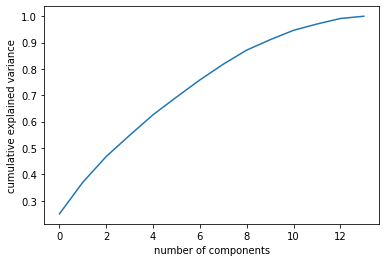

In [20]:
pca = PCA().fit(tracks_stand)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [21]:
pca = PCA(n_components=8)

In [22]:
tracks_pca = pd.DataFrame(
    pca.fit_transform(tracks_stand),
    index=tracks_stand.index,
    columns=['PCA_{}'.format(i) for i in range(8)]
)

tracks_pca.head(5)

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,3.935540,2.159815,3.058879,0.759737,2.204105,2.398029,0.287578,2.965406
1,0.320080,-3.028879,-1.132489,-0.158923,0.018694,1.756644,-0.525421,0.856703
2,3.447074,1.664718,1.012539,0.139807,-0.543012,0.122817,1.183469,1.426392
3,1.869256,0.669566,0.383202,1.340511,0.332788,0.290141,-1.233756,-0.646438
4,1.845010,0.053930,-0.351891,0.956631,-0.506166,0.158227,-0.711005,-0.623546


In [23]:
tracks_pca = pd.DataFrame(
    scaler.fit_transform(tracks_pca),
    index=tracks_pca.index,
    columns=tracks_pca.columns
).reset_index(drop=True)

tracks_pca.head(5)

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,2.104233,1.665265,2.614741,0.715856,2.109592,2.474589,0.301299,3.241327
1,0.171139,-2.335332,-0.968056,-0.149744,0.017893,1.812727,-0.550490,0.936417
2,1.843062,1.283534,0.865522,0.131732,-0.519728,0.126738,1.239936,1.559113
3,0.999444,0.516250,0.327562,1.263085,0.318518,0.299404,-1.292621,-0.706587
4,0.986480,0.041581,-0.300797,0.901378,-0.484462,0.163279,-0.744929,-0.681565


In [24]:
for ind, comp in enumerate(pca.components_):
    text = f"PCA_{ind} = (\n"
    for i, val in enumerate(comp):
        if i != len(comp) - 1:
            text += f"\t{val:<21} * {tracks_stand.columns[i]} + \n"
        else:
            text += f"\t{val:<21} * {tracks_stand.columns[i]}\n)"
    print(text, '\n')            

PCA_0 = (
	-0.25151583409759126  * valence + 
	0.4362231399431232    * acousticness + 
	-0.27381498573233987  * danceability + 
	0.021810961872867175  * duration_ms + 
	-0.4581834511631123   * energy + 
	-0.16694213422773313  * explicit + 
	0.2925295794060037    * instrumentalness + 
	-0.022384662206511245 * key + 
	-0.025840084349672023 * liveness + 
	-0.44161740793534343  * loudness + 
	0.02657396265241439   * mode + 
	-0.3494428514536892   * popularity + 
	-0.021963975899762355 * speechiness + 
	-0.16771961950213168  * tempo
) 

PCA_1 = (
	-0.2785002973820635   * valence + 
	-0.12244265582021178  * acousticness + 
	-0.4316531690383597   * danceability + 
	0.318573124594292     * duration_ms + 
	0.18469916241988601   * energy + 
	-0.37155286115715164  * explicit + 
	0.12479722939500267   * instrumentalness + 
	-0.04436438666234234  * key + 
	-0.03196872904155909  * liveness + 
	0.15735693408204673   * loudness + 
	0.061280292835696214  * mode + 
	0.24181574322129554   * popularity + 

In [25]:
kmeans = KMeans(n_clusters=4, random_state=8888).fit(tracks_pca)

In [26]:
tracks_pca['cluster'] = kmeans.labels_

In [28]:
groups = tracks_pca.iloc[tracks_stand.reset_index(drop=True).sort_values(by='popularity', ascending=False).iloc[:1000].index.values].groupby('cluster')

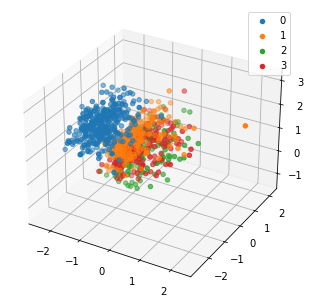

In [29]:
fig = plt.figure() 
ax = Axes3D(fig) 

for name, group in groups:     
    ax.scatter(
        group['PCA_0'].values, 
        group['PCA_1'].values, 
        group['PCA_2'].values, 
        marker="o", label=name
    )

ax.legend() 
plt.show()